In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
import os
from numpy.lib.recfunctions import append_fields
import scipy.stats

import matplotlib.pyplot as plt
import numpy as np
from run_systematics import sys_iteration, weightmultiply, fitting_allSP, calling_sysMap

from sys_functions import *

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [21]:
def number_gal_update(sysMap, dmass_chron, dmass_chron_weights, sys_weights = False, mocks = False, iterative = False): # apply systematic weights here
    
    #minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
    #maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
    import numpy
    
    # create binning in area option:
    percentile  = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    # Calculate the bin edges
    bin_edges = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], percentile)
    pbin = bin_edges 
    #print(pbin)
    
    # Calculate the bin widths
    bin_widths = np.diff(bin_edges)
    #print(bin_widths)

    #pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
    data = sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN]
    digitized = numpy.digitize(data, pbin)
    pmean = [data[digitized == i].mean() for i in range(1, len(pbin))]
    print(pmean)
'''
    x = np.full(hp.nside2npix(4096), hp.UNSEEN)
    x[sysMap['PIXEL']] = sysMap['SIGNAL']
    if mocks != True:
        sysval_gal = x[dmass_chron['HPIX_4096']].copy()
        
    else: 
        sysval_gal = x[dmass_chron].copy()
    
    if mocks != True:
        if sys_weights == True:
            print("weights being applied...")
            h,_ = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["CMASS_PROB"][sysval_gal != hp.UNSEEN]*dmass_chron_weights[sysval_gal != hp.UNSEEN])
        else:
            if iterative != True:
                h,_ = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["CMASS_PROB"][sysval_gal != hp.UNSEEN]) # -- density of dmass sample, not gold sample
        if iterative == True:
            print("weights being applied...")
            h,_ = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["CMASS_PROB"][sysval_gal != hp.UNSEEN]*dmass_chron_weights[sysval_gal != hp.UNSEEN])
    else:
        h,_ = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron_weights[sysval_gal != hp.UNSEEN])
    
    return h, sysval_gal
'''

'\n    x = np.full(hp.nside2npix(4096), hp.UNSEEN)\n    x[sysMap[\'PIXEL\']] = sysMap[\'SIGNAL\']\n    if mocks != True:\n        sysval_gal = x[dmass_chron[\'HPIX_4096\']].copy()\n        \n    else: \n        sysval_gal = x[dmass_chron].copy()\n    \n    if mocks != True:\n        if sys_weights == True:\n            print("weights being applied...")\n            h,_ = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["CMASS_PROB"][sysval_gal != hp.UNSEEN]*dmass_chron_weights[sysval_gal != hp.UNSEEN])\n        else:\n            if iterative != True:\n                h,_ = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["CMASS_PROB"][sysval_gal != hp.UNSEEN]) # -- density of dmass sample, not gold sample\n        if iterative == True:\n            print("weights being applied...")\n            h,_ = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["CMASS_PROB"][sysval_gal != hp.UNSEE

In [3]:
dmass_spt = calling_catalog('/fs/scratch/PCON0008/warner785/bwarner/dmass_spt.fits')
index_mask = np.argsort(dmass_spt)
dmass_chron = dmass_spt[index_mask] # ordered by hpix values
dmass_chron['HPIX_4096'] = hp.nest2ring(4096, dmass_chron['HPIX_4096'])

path = '/fs/scratch/PCON0008/warner785/bwarner/'
fracDet = fitsio.read(path+'y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz')
frac = np.zeros(hp.nside2npix(4096))
fracDet["PIXEL"] = hp.nest2ring(4096, fracDet['PIXEL'])
frac[fracDet['PIXEL']] = fracDet['SIGNAL']
fracHp = np.full(hp.nside2npix(4096), hp.UNSEEN)
fracHp[fracDet['PIXEL']] = fracDet['SIGNAL']

sysMap = io.SearchAndCallFits(path = '/fs/scratch/PCON0008/warner785/bwarner/pca_SP107_SPT_v2_cformat/', keyword = 'pc0_') 
frac_weight = fracHp[sysMap['PIXEL']]
sysMap = sysMap[frac_weight != hp.UNSEEN]

Resulting catalog size
DMASS= 341117.6414259936

Calling catalogs >>>
pc0_SP107_SPT_v2_cformat_4096ring.fits.gz
reading 1/1 /fs/scratch/PCON0008/warner785/bwarner/pca_SP107_SPT_v2_cformat/pc0_SP107_SPT_v2_cformat_4096ring.fits.gz


In [22]:
number_gal_update(sysMap, dmass_chron, None)

[-7.3441375835208635, -4.420084188284406, -2.9717047980856086, -1.7998364863305951, -0.7439502895798059, 0.30524848049474823, 1.4498064442404612, 2.7697097047561217, 4.502442826254022, 8.253282633599808]


In [ ]:
# area in total: 16690111.25
# area for each bin: 1390842.60416667

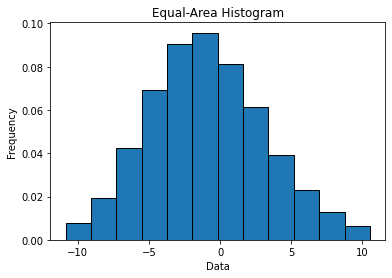

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data
sys_signal = sysMap['SIGNAL']
data = sys_signal[sys_signal != hp.UNSEEN]*frac_weight

# Calculate the number of bins
#num_bins = int(np.sqrt(len(data)))
num_bins = 11

minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)

percentile  = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Calculate the bin edges
bin_edges = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], percentile)

# Calculate the bin widths
bin_widths = np.diff(bin_edges)

# Calculate the bin heights
bin_heights, _ = np.histogram(data, bins=bin_edges)

# Normalize the bin heights so that the area of each bin is 1
bin_heights = bin_heights / (bin_widths * len(data))

# Plot the histogram
plt.bar(bin_edges[:-1], bin_heights, width=bin_widths, edgecolor='black')
plt.title('Equal-Area Histogram')
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.show()

In [16]:
print(bin_widths)
print(bin_heights)

[1.78418923 1.78418923 1.78418923 1.78418923 1.78418923 1.78418923
 1.78418923 1.78418923 1.78418923 1.78418923 1.78418923 1.78418923]
[0.0078795  0.01927601 0.04224286 0.06940365 0.09058717 0.09571244
 0.08141609 0.06145758 0.03922109 0.02324521 0.01300855 0.00647664]
